In [1]:
# Option B Pipeline: Pseudo‑Label Fine‑Tuning on MarBERT (using full 21k unlabeled)

# 0) (Optional) Install dependencies
!pip install torch==2.5.1+cu124 torchvision==0.20.1+cu124 --extra-index-url https://download.pytorch.org/whl/cu124




import pandas as pd
import numpy as np
import torch
import math
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# 1) Device
device = "cuda" if torch.cuda.is_available() else "cpu"








Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu124


In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
# 2) Loader for labeled splits
def load_split(path):
    df = pd.read_csv(path, sep="\t")
    df = df.rename(columns={
        "sentence": "text",
        "average_dialectness_level": "label"
    })
    df["label"] = df["label"].astype(float)
    return Dataset.from_pandas(df)

train_ds = load_split("/content/train.tsv")
dev_ds   = load_split("/content/dev.tsv")
test_ds  = load_split("/content/test.tsv")




# 3) Load full unlabeled pool (21k)
df_unlab = pd.read_csv("/content/unlabeled.tsv", sep="\t", encoding="latin1")
text_col = [c for c in df_unlab.columns if "tweet" in c.lower()][0]
texts_unlab = df_unlab[text_col].astype(str).tolist()



print("labeled train:", len(train_ds))      # should be ~19–23 K
print("unlabeled pool:", len(df_unlab))     # should be ~21 K



labeled train: 102886
unlabeled pool: 21000


In [4]:
# 4) Tokenizer & base model for embeddings
MODEL_NAME  = "UBC-NLP/MARBERTv2"
tokenizer   = AutoTokenizer.from_pretrained(MODEL_NAME)
embed_model = AutoModel.from_pretrained(MODEL_NAME).to(device)
embed_model.eval()

def get_cls_embeddings(texts, batch_size=32):
    embs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        toks  = tokenizer(batch, padding=True, truncation=True,
                          max_length=128, return_tensors="pt").to(device)
        with torch.no_grad():
            hidden = embed_model(**toks).last_hidden_state
        embs.append(hidden[:,0].cpu().numpy())
    return np.vstack(embs)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:

# 5) Embed training and unlabeled
X_train      = get_cls_embeddings(train_ds["text"])
y_train      = np.array(train_ds["label"])
X_unlab_full = get_cls_embeddings(texts_unlab)


In [6]:
# 6) K-Means on train
num_clusters   = len(np.unique(y_train))
km             = KMeans(n_clusters=num_clusters, random_state=42).fit(X_train)
clusters_train = km.labels_


In [7]:

# 7) Build cluster → mean‑label map
global_mean   = y_train.mean()
cluster_means = {
    c: np.mean([lbl for lbl, cl in zip(y_train, clusters_train) if cl == c])
       if np.any(clusters_train == c) else global_mean
    for c in range(num_clusters)
}

In [8]:

# 8) Pseudo-label all 21k unlabeled
clusters_unlab = km.predict(X_unlab_full)
pseudo_labels  = [cluster_means[int(c)] for c in clusters_unlab]

# Sanity check
unique = np.unique(pseudo_labels)
print(f"Using all {len(pseudo_labels)} pseudo-labels; "
      f"{len(unique)} unique; range {unique.min():.4f}–{unique.max():.4f}")



Using all 21000 pseudo-labels; 13 unique; range 0.1226–0.4955


In [10]:

# 10) Tokenize for regression
def preprocess(batch):
    toks = tokenizer(batch["text"],
                     padding="max_length",
                     truncation=True,
                     max_length=128)
    toks["labels"] = batch["label"]
    return toks

aug_tok  = aug_ds.map(preprocess, batched=True)
dev_tok  = dev_ds.map(preprocess,   batched=True)
test_tok = test_ds.map(preprocess,  batched=True)

print("Training examples:", len(aug_tok))

Map:   0%|          | 0/123886 [00:00<?, ? examples/s]

Map:   0%|          | 0/12260 [00:00<?, ? examples/s]

Map:   0%|          | 0/12689 [00:00<?, ? examples/s]

Training examples: 123886


In [11]:
# 9) Build augmented DF & HF Dataset
df_real   = pd.DataFrame({"text": train_ds["text"],    "label": y_train})
df_pseudo = pd.DataFrame({"text": texts_unlab,         "label": pseudo_labels})
df_aug    = pd.concat([df_real, df_pseudo], ignore_index=True)
print(f"Augmented size = {len(df_aug)}")  # ~19k + 21k = ~40k
aug_ds  = Dataset.from_pandas(df_aug)
aug_tok = aug_ds.map(preprocess, batched=True)
print(len(aug_tok))  # 123886




Augmented size = 123886


Map:   0%|          | 0/123886 [00:00<?, ? examples/s]

123886


In [16]:
# 11) Regression head & metrics
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=1, problem_type="regression"
).to(device)



def compute_metrics(pred):
    preds  = pred.predictions.squeeze(-1)
    labels = pred.label_ids.astype(np.float32)
    mse    = mean_squared_error(labels, preds)
    rmse   = math.sqrt(mse)
    mae    = mean_absolute_error(labels, preds)
    return {"mse": mse, "rmse": rmse, "mae": mae}



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
args = TrainingArguments(
    output_dir                 = "./marbert_pseudo21k",
    learning_rate              = 2e-5,
    per_device_train_batch_size= 16,
    per_device_eval_batch_size = 32,
    num_train_epochs           = 3,
    logging_steps              = 50,
    save_total_limit           = 1,
    report_to                  = [],
    run_name                   = "marbert_pseudo21k",
    fp16                       = True,
)

trainer = Trainer(
    model           = model,
    args            = args,
    train_dataset   = aug_tok,   # ← now points at 123,886 examples
    eval_dataset    = dev_tok,
    compute_metrics = compute_metrics,
)

In [18]:
# Right before you call trainer.train(), print these:
print("HF Dataset length (aug_ds):", len(aug_ds))
print("Tokenized length (aug_tok):", len(aug_tok))


HF Dataset length (aug_ds): 123886
Tokenized length (aug_tok): 123886


In [19]:

# 13) Fine-tune & evaluate
trainer.train()
dev_res  = trainer.evaluate()
test_res = trainer.predict(test_tok).metrics

print(f"Dev RMSE:  {dev_res['eval_rmse']:.4f}")
print(f"Test RMSE: {test_res['test_rmse']:.4f}")

Step,Training Loss
50,0.074900
100,0.041000
150,0.039900
200,0.034800
250,0.037900
300,0.028800
350,0.030200
400,0.032200
450,0.033200
500,0.031700


Dev RMSE:  0.1708
Test RMSE: 0.1718


RMSE: 0.1718
MAE: 0.1012
R² Score: 0.7504


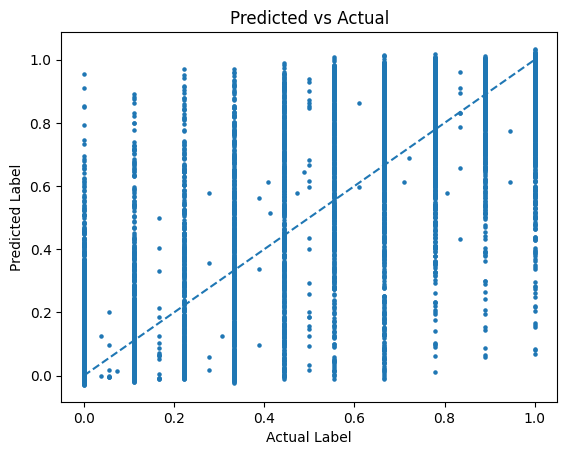

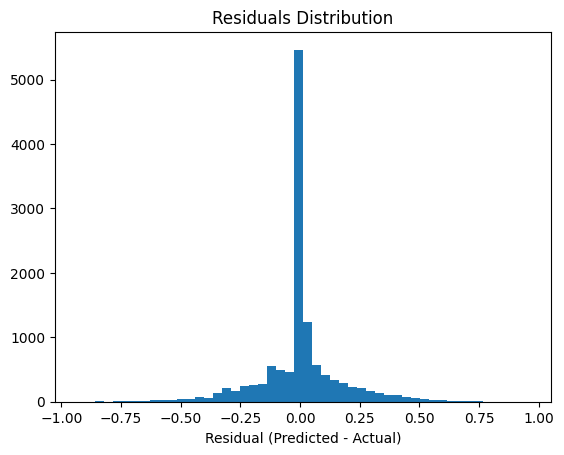

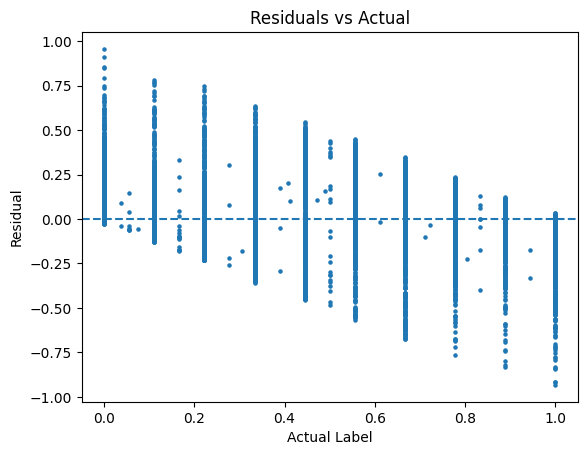

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ensure this runs in the same notebook/session where 'trainer' and 'test_tok' exist
if 'trainer' not in globals() or 'test_tok' not in globals():
    raise RuntimeError("Please run this cell after you have defined 'trainer' and 'test_tok' from your training script.")

# 1) Run prediction on the test set
pred_output = trainer.predict(test_tok)
preds = pred_output.predictions.squeeze()
labels = pred_output.label_ids
residuals = preds - labels

# 2) Compute error metrics
rmse = np.sqrt(mean_squared_error(labels, preds))
mae = mean_absolute_error(labels, preds)
r2  = r2_score(labels, preds)
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# 3) Scatter plot: Predicted vs. Actual
plt.figure()
plt.scatter(labels, preds, s=5)
plt.plot([labels.min(), labels.max()], [labels.min(), labels.max()], linestyle='--')
plt.xlabel('Actual Label')
plt.ylabel('Predicted Label')
plt.title('Predicted vs Actual')
plt.show()

# 4) Histogram: Distribution of residuals
plt.figure()
plt.hist(residuals, bins=50)
plt.xlabel('Residual (Predicted - Actual)')
plt.title('Residuals Distribution')
plt.show()

# 5) Scatter plot: Residuals vs. Actual
plt.figure()
plt.scatter(labels, residuals, s=5)
plt.axhline(0, linestyle='--')
plt.xlabel('Actual Label')
plt.ylabel('Residual')
plt.title('Residuals vs Actual')
plt.show()


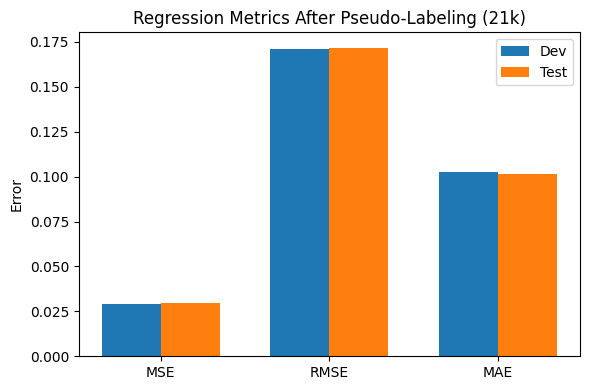

In [21]:
# 14) Plot errors
labels_err = ["mse","rmse","mae"]
dev_errs   = [dev_res[f"eval_{e}"]  for e in labels_err]
test_errs  = [test_res[f"test_{e}"] for e in labels_err]
x = np.arange(len(labels_err)); width = 0.35

plt.figure(figsize=(6,4))
plt.bar(x - width/2, dev_errs,  width, label="Dev")
plt.bar(x + width/2, test_errs, width, label="Test")
plt.xticks(x, [e.upper() for e in labels_err])
plt.ylabel("Error")
plt.title("Regression Metrics After Pseudo-Labeling (21k)")
plt.legend()
plt.tight_layout()
plt.show()

# **Supervised-Only**

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/102886 [00:00<?, ? examples/s]

Map:   0%|          | 0/12260 [00:00<?, ? examples/s]

Map:   0%|          | 0/12689 [00:00<?, ? examples/s]

Step,Training Loss
50,0.092700
100,0.052700
150,0.040400
200,0.042800
250,0.039300
300,0.039700
350,0.031900
400,0.038900
450,0.039900
500,0.033000


Supervised‐only Dev RMSE:  0.1681
Supervised‐only Test RMSE: 0.1690


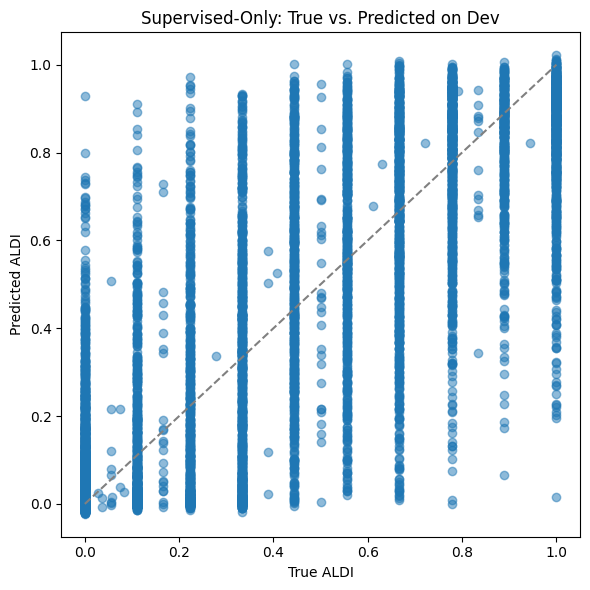

In [22]:
# Supervised‐Only MarBERT Regression Baseline


model      = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=1,
    problem_type="regression"
).to(device)

# 4) Tokenize splits
def preprocess(batch):
    toks = tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )
    toks["labels"] = batch["label"]
    return toks

train_tok = train_ds.map(preprocess, batched=True)
dev_tok   = dev_ds.map(preprocess,   batched=True)
test_tok  = test_ds.map(preprocess,  batched=True)

# 5) Metrics function
def compute_metrics_sup(pred):
    preds  = pred.predictions.squeeze(-1)
    labels = pred.label_ids.astype(float)
    mse    = mean_squared_error(labels, preds)
    rmse   = math.sqrt(mse)
    mae    = mean_absolute_error(labels, preds)
    return {"mse": mse, "rmse": rmse, "mae": mae}

# 6) TrainingArguments for supervised‐only run
sup_args = TrainingArguments(
    output_dir                 = "./marbert_supervised",
    learning_rate              = 2e-5,
    per_device_train_batch_size= 16,
    per_device_eval_batch_size = 32,
    num_train_epochs           = 3,
    logging_steps              = 50,
    save_total_limit           = 1,
    report_to                  = [],
    run_name                   = "marbert_supervised_reg",
    fp16                       = True,
)

# 7) Trainer setup
sup_trainer = Trainer(
    model           = model,
    args            = sup_args,
    train_dataset   = train_tok,
    eval_dataset    = dev_tok,
    compute_metrics = compute_metrics_sup,
)

# 8) Fine‐tune on true labels only
sup_trainer.train()

# 9) Evaluate on dev and test
sup_dev_res  = sup_trainer.evaluate()
sup_test_res = sup_trainer.predict(test_tok).metrics

print(f"Supervised‐only Dev RMSE:  {sup_dev_res['eval_rmse']:.4f}")
print(f"Supervised‐only Test RMSE: {sup_test_res['test_rmse']:.4f}")

# 10) (Optional) Plot predictions vs. truth on dev
dev_out   = sup_trainer.predict(dev_tok)
dev_preds = dev_out.predictions.squeeze(-1)
dev_true  = dev_out.label_ids

plt.figure(figsize=(6,6))
plt.scatter(dev_true, dev_preds, alpha=0.5)
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("True ALDI")
plt.ylabel("Predicted ALDI")
plt.title("Supervised‐Only: True vs. Predicted on Dev")
plt.tight_layout()
plt.show()



Error Analysis on Test Set
  RMSE: 0.1690
  MAE : 0.1001
  R²  : 0.7583


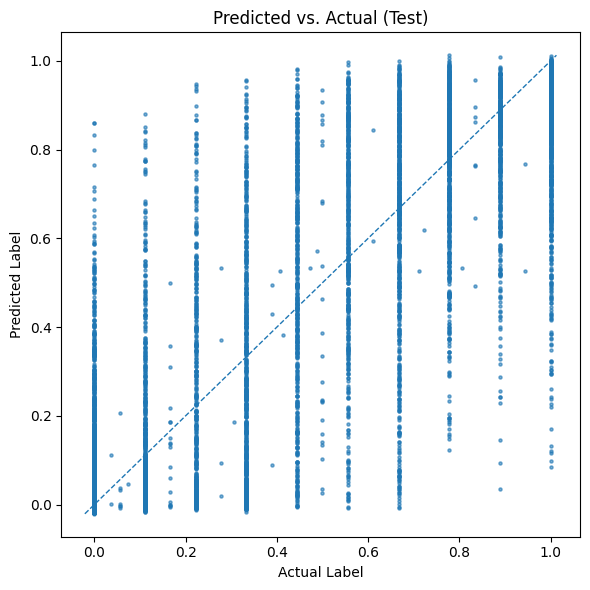

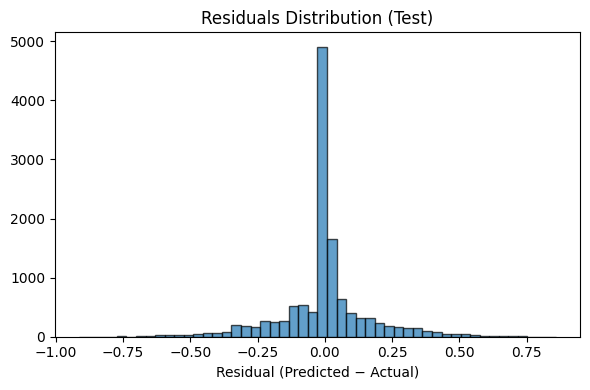

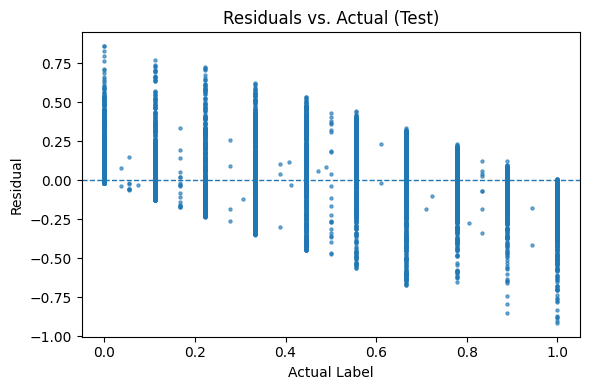

In [23]:
# (2) Error‐analysis on the **test** set

# 2.1) Get predictions & true labels
pred_out = sup_trainer.predict(test_tok)
preds    = pred_out.predictions.squeeze(-1)
labels   = pred_out.label_ids.astype(float)
resids   = preds - labels

# 2.2) Compute and print summary metrics including R²
rmse = np.sqrt(mean_squared_error(labels, preds))
mae  = mean_absolute_error(labels, preds)
r2   = r2_score(labels, preds)
print(f"\nError Analysis on Test Set")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE : {mae:.4f}")
print(f"  R²  : {r2:.4f}")

# 2.3) Plot: Predicted vs. Actual
plt.figure(figsize=(6,6))
plt.scatter(labels, preds, s=5, alpha=0.6)
mn, mx = min(labels.min(), preds.min()), max(labels.max(), preds.max())
plt.plot([mn, mx], [mn, mx], "--", linewidth=1)
plt.xlabel("Actual Label")
plt.ylabel("Predicted Label")
plt.title("Predicted vs. Actual (Test)")
plt.tight_layout()
plt.show()

# 2.4) Plot: Residuals Distribution
plt.figure(figsize=(6,4))
plt.hist(resids, bins=50, edgecolor="black", alpha=0.7)
plt.xlabel("Residual (Predicted − Actual)")
plt.title("Residuals Distribution (Test)")
plt.tight_layout()
plt.show()

# 2.5) Plot: Residuals vs. Actual
plt.figure(figsize=(6,4))
plt.scatter(labels, resids, s=5, alpha=0.6)
plt.axhline(0, linestyle="--", linewidth=1)
plt.xlabel("Actual Label")
plt.ylabel("Residual")
plt.title("Residuals vs. Actual (Test)")
plt.tight_layout()
plt.show()

# Two‐Stage Fine-Tuning: Supervised → Pseudo-Labeled on the Same **Model** bold text

In [ ]:
# Two‐Stage Fine-Tuning: Supervised → Pseudo-Labeled on the Same Model
# with Corrected Metric Computation, CPU Fallback, Error Analysis & Graphs

import os
# Disable GPU to avoid CUDA library errors
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    AutoModel
)
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1) Force CPU device
device = torch.device("cpu")

# 2) Load labeled splits
def load_split(path):
    df = pd.read_csv(path, sep="\t")
    df = df.rename(columns={"sentence": "text", "average_dialectness_level": "label"})
    df["label"] = df["label"].astype(float)
    return Dataset.from_pandas(df)

train_ds = load_split("/content/train.tsv")
dev_ds   = load_split("/content/dev.tsv")
test_ds  = load_split("/content/test.tsv")

# 3) Load unlabeled pool + pseudo-label
df_unlab    = pd.read_csv("/content/unlabeled.tsv", sep="\t", encoding="latin1")
text_col    = [c for c in df_unlab.columns if "tweet" in c.lower()][0]
texts_unlab = df_unlab[text_col].astype(str).tolist()

# 4) Embed with MarBERT
MODEL_NAME  = "UBC-NLP/MARBERTv2"
tokenizer   = AutoTokenizer.from_pretrained(MODEL_NAME)
embed_model = AutoModel.from_pretrained(MODEL_NAME).to(device)
embed_model.eval()

def get_cls_embeddings(texts, batch_size=32):
    embs = []
    for i in range(0, len(texts), batch_size):
        toks = tokenizer(texts[i:i+batch_size],
                         padding=True, truncation=True,
                         max_length=128, return_tensors="pt").to(device)
        with torch.no_grad():
            hidden = embed_model(**toks).last_hidden_state
        embs.append(hidden[:,0].cpu().numpy())
    return np.vstack(embs)

X_train = get_cls_embeddings(train_ds["text"])
y_train = np.array(train_ds["label"])
km = KMeans(n_clusters=len(np.unique(y_train)), random_state=42).fit(X_train)
clusters_train = km.labels_
cluster_means = {
    c: np.mean(y_train[clusters_train == c])
    for c in np.unique(clusters_train)
}
X_unlab        = get_cls_embeddings(texts_unlab)
clusters_unlab = km.predict(X_unlab)
pseudo_labels  = [cluster_means[c] for c in clusters_unlab]

# 5) Tokenization helper
def preprocess(batch):
    toks = tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)
    toks["labels"] = batch["label"]
    return toks

train_tok = train_ds.map(preprocess, batched=True)
dev_tok   = dev_ds.map(preprocess,   batched=True)
test_tok  = test_ds.map(preprocess,  batched=True)

# 6) Corrected metrics function
def compute_metrics_sup(pred):
    preds  = pred.predictions.squeeze(-1)
    labels = pred.label_ids.astype(float)
    mse    = mean_squared_error(labels, preds)
    return {
        "mse": mse,
        "rmse": math.sqrt(mse),
        "mae": mean_absolute_error(labels, preds)
    }

# 7) Supervised-only fine-tuning
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=1, problem_type="regression"
).to(device)

sup_args = TrainingArguments(
    output_dir                  ="./marbert_supervised",
    learning_rate               =2e-5,
    per_device_train_batch_size =16,
    per_device_eval_batch_size  =32,
    num_train_epochs            =3,
    logging_steps               =50,
    save_total_limit            =1,
    report_to                   =[],
    run_name                    ="marbert_supervised_reg",
    fp16                        =False,
)

sup_trainer = Trainer(
    model           =model,
    args            =sup_args,
    train_dataset   =train_tok,
    eval_dataset    =dev_tok,
    compute_metrics =compute_metrics_sup,
)
sup_trainer.train()

# 8) Error Analysis After Supervised Only
sup_out    = sup_trainer.predict(test_tok)
sup_preds  = sup_out.predictions.squeeze(-1)
labels     = sup_out.label_ids.astype(float)
sup_resids = sup_preds - labels

rmse_sup = math.sqrt(mean_squared_error(labels, sup_preds))
mae_sup  = mean_absolute_error(labels, sup_preds)
r2_sup   = r2_score(labels, sup_preds)
print(f"\n[Supervised-only] Test RMSE: {rmse_sup:.4f}, MAE: {mae_sup:.4f}, R²: {r2_sup:.4f}")

# Diagnostic plots
plt.figure(figsize=(5,5))
plt.scatter(labels, sup_preds, s=5, alpha=0.6); mn, mx = labels.min(), labels.max()
plt.plot([mn,mx],[mn,mx],"--"); plt.xlabel("Actual"); plt.ylabel("Predicted")
plt.title("Supervised-only: Pred vs Actual"); plt.tight_layout(); plt.show()

plt.figure(figsize=(5,4))
plt.hist(sup_resids, bins=50, edgecolor="black", alpha=0.7)
plt.xlabel("Residual"); plt.title("Supervised-only: Residual Dist"); plt.tight_layout(); plt.show()

plt.figure(figsize=(5,4))
plt.scatter(labels, sup_resids, s=5, alpha=0.6)
plt.axhline(0, linestyle="--"); plt.xlabel("Actual"); plt.ylabel("Residual")
plt.title("Supervised-only: Resid vs Actual"); plt.tight_layout(); plt.show()

# 9) Pseudo-labeled fine-tuning (continuation)
pseudo_ds  = Dataset.from_pandas(pd.DataFrame({"text": texts_unlab, "label": pseudo_labels}))
pseudo_tok = pseudo_ds.map(preprocess, batched=True)

pseudo_args = TrainingArguments(
    output_dir                  ="./marbert_pseudo_finetune_full",
    learning_rate               =2e-5,
    per_device_train_batch_size =16,
    per_device_eval_batch_size  =32,
    num_train_epochs            =1,
    logging_steps               =50,
    save_total_limit            =1,
    report_to                   =[],
    run_name                    ="marbert_pseudo_full_finetune",
    fp16                        =False,
)

pseudo_trainer = Trainer(
    model           =sup_trainer.model,
    args            =pseudo_args,
    train_dataset   =pseudo_tok,
    eval_dataset    =dev_tok,
    compute_metrics =compute_metrics_sup,
)
pseudo_trainer.train()

# 10) Error Analysis After Pseudo-Fine-Tuning
pseudo_out     = pseudo_trainer.predict(test_tok)
pseudo_preds   = pseudo_out.predictions.squeeze(-1)
pseudo_resids  = pseudo_preds - labels

rmse_pseudo = math.sqrt(mean_squared_error(labels, pseudo_preds))
mae_pseudo  = mean_absolute_error(labels, pseudo_preds)
r2_pseudo   = r2_score(labels, pseudo_preds)
print(f"\n[After Pseudo] Test RMSE: {rmse_pseudo:.4f}, MAE: {mae_pseudo:.4f}, R²: {r2_pseudo:.4f}")

# Comparative Bar Chart
metrics = ["RMSE","MAE","R²"]
vals_sup    = [rmse_sup, mae_sup, r2_sup]
vals_pseudo = [rmse_pseudo, mae_pseudo, r2_pseudo]
x = np.arange(len(metrics)); w=0.35

plt.figure(figsize=(5,4))
plt.bar(x-w/2, vals_sup,    w, label="Supervised")
plt.bar(x+w/2, vals_pseudo, w, label="After Pseudo")
plt.xticks(x, metrics); plt.ylabel("Value"); plt.title("Supervised vs. After-Pseudo")
plt.legend(); plt.tight_layout(); plt.show()

# Overlay Pred vs Actual Comparison
plt.figure(figsize=(5,5))
plt.scatter(labels, sup_preds,    s=5, alpha=0.5, label="Supervised")
plt.scatter(labels, pseudo_preds, s=5, alpha=0.5, label="After-Pseudo")
plt.plot([mn,mx],[mn,mx],"--", color="gray")
plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.title("Pred vs Actual Comparison")
plt.legend(); plt.tight_layout(); plt.show()

# Overlay Residual Distributions
plt.figure(figsize=(5,4))
plt.hist(sup_resids,    bins=50, alpha=0.5, label="Supervised")
plt.hist(pseudo_resids, bins=50, alpha=0.5, label="After-Pseudo")
plt.xlabel("Residual"); plt.title("Residuals Dist Comparison")
plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ensure the required objects exist
if 'sup_trainer' not in globals() or 'pseudo_trainer' not in globals() or 'test_tok' not in globals():
    raise RuntimeError("Please run the cells that define and train 'sup_trainer', 'pseudo_trainer', and prepare 'test_tok' first.")

# 1) Predictions
sup_out      = sup_trainer.predict(test_tok)
sup_preds    = sup_out.predictions.squeeze(-1)
labels       = sup_out.label_ids.astype(float)
sup_resids   = sup_preds - labels

pseudo_out   = pseudo_trainer.predict(test_tok)
pseudo_preds = pseudo_out.predictions.squeeze(-1)
pseudo_resids= pseudo_preds - labels

# 2) Metrics
def all_metrics(true, pred):
    return {
        "RMSE": np.sqrt(mean_squared_error(true, pred)),
        "MAE":  mean_absolute_error(true, pred),
        "R²":   r2_score(true, pred)
    }

sup_metrics    = all_metrics(labels, sup_preds)
pseudo_metrics = all_metrics(labels, pseudo_preds)

print("🔹 Supervised-only Metrics:", sup_metrics)
print("🔹 After-Pseudo Metrics:  ", pseudo_metrics)

# 3) Bar Chart Comparison
metrics_names = list(sup_metrics.keys())
sup_vals      = [sup_metrics[m] for m in metrics_names]
pseudo_vals   = [pseudo_metrics[m] for m in metrics_names]

x = np.arange(len(metrics_names))
w = 0.35

plt.figure(figsize=(6,4))
plt.bar(x - w/2, sup_vals, width=w, label='Supervised-only')
plt.bar(x + w/2, pseudo_vals, width=w, label='After-Pseudo')
plt.xticks(x, metrics_names)
plt.ylabel('Value')
plt.title('Performance Metrics Comparison')
plt.legend()
plt.tight_layout()
plt.show()

# 4) Predicted vs Actual Overlay
plt.figure(figsize=(6,6))
plt.scatter(labels, sup_preds,    s=5, alpha=0.5, label='Supervised-only')
plt.scatter(labels, pseudo_preds, s=5, alpha=0.5, label='After-Pseudo')
mn = min(labels.min(), sup_preds.min(), pseudo_preds.min())
mx = max(labels.max(), sup_preds.max(), pseudo_preds.max())
plt.plot([mn, mx], [mn, mx], '--', linewidth=1, label='Ideal')
plt.xlabel('Actual Label')
plt.ylabel('Predicted Label')
plt.title('Predicted vs Actual Comparison')
plt.legend()
plt.tight_layout()
plt.show()

# 5) Residuals Distribution Comparison
plt.figure(figsize=(6,4))
plt.hist(sup_resids,    bins=50, alpha=0.5, label='Supervised-only')
plt.hist(pseudo_resids, bins=50, alpha=0.5, label='After-Pseudo')
plt.xlabel('Residual')
plt.title('Residuals Distribution Comparison')
plt.legend()
plt.tight_layout()
plt.show()
